# Exercise: Nonlinear Programming¶

In [1]:
import os
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import DM, MX, Function
import casadi as cas
from platform import python_version

print(f"Casadi: {cas.__version__}")
print(f"Python: {python_version()}")

Casadi: 3.6.7
Python: 3.10.16


In [2]:
plot_dir = 'plots'
os.makedirs(plot_dir, exist_ok=True)

## Golf Ball Problem

$$
\begin{aligned}
\begin{cases}
    &\dot{\mathbf{p}} = \mathbf{v} \\
    &\dot{\mathbf{v}} = \mathbf{g} - \frac{1}{m} c \| \mathbf{v} \|_2 \mathbf{v}
\end{cases}
\end{aligned}
$$

where

$$
\begin{aligned}
\mathbf{p} = \left[ \begin{matrix} x \\ y \end{matrix} \right],
\mathbf{v} = \left[ \begin{matrix} v_x \\ v_y \end{matrix} \right],
\mathbf{g} = \left[ \begin{matrix} 0 \\ -g \end{matrix} \right]
\end{aligned}
$$

## 1. Integrating the golf ball’s state

### 1.1 CasADi expression for the ODE

In [3]:
p = MX.sym('p', 2)
v = MX.sym('v', 2)

# Constants
m = DM(0.04593)
g = cas.sparsify(DM([0, -9.81]))
c = DM(17.5e-5)
g

DM([00, -9.81])

In [4]:
rhs = cas.vertcat(
    v,
    g - c * cas.norm_2(v) * v / m
)

assert rhs.shape == (4, 1)
rhs

MX(vertcat(v, ([0, -9.81]-(((0.000175*||v||_F)*v)/0.04593))))

In [5]:
f = Function('rhs', [cas.vertcat(p, v)], [rhs])
f

Function(rhs:(i0[4])->(o0[4]) MXFunction)

In [6]:
assert_array_almost_equal(
    f([0.0, 0.0, 35.0, 30.0]), 
    [[35], [30], [-6.14737], [-15.0792]], 
    decimal=4
)

### 1.2. Create a CasADi integrator

In [7]:
ode = {'x': cas.vertcat(p, v), 'ode': rhs}
t0, t1 = 0., 1.
intg = cas.integrator('intg', 'cvodes', ode, t0, t1)
intg

Function(intg:(x0[4],z0[0],p[0],u[0],adj_xf[],adj_zf[],adj_qf[])->(xf[4],zf[0],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) CvodesInterface)

In [8]:
x0 = [0.0, 0.0, 35.0, 30.0]
xf, _, _, _, _, _, _ = intg(x0, [], [], [], [], [], [])
xf

DM([32.3549, 23.0661, 30.075, 16.6423])

In [9]:
assert_array_almost_equal(xf, [[32.3549], [23.0661], [30.075], [16.6423]], decimal=4)

In [10]:
# You can also use this syntax
xf = intg(x0=x0)['xf']
xf

DM([32.3549, 23.0661, 30.075, 16.6423])

In [11]:
assert_array_almost_equal(xf, [[32.3549], [23.0661], [30.075], [16.6423]], decimal=4)

## 2. Determining the reach of the golf ball

### 2.1 Function to compute state in one second

In [12]:
X0 = MX.sym('X0', 4)
fly1sec = Function('fly1sec', [X0], [intg(x0=X0)['xf']], ['X0'], ['Xf'])
fly1sec

Function(fly1sec:(X0[4])->(Xf[4]) MXFunction)

In [13]:
x1 = fly1sec([0.0,0.0,35.0,20.0])
x1

DM([32.6405, 13.9607, 30.5608, 8.26437])

In [14]:
assert_array_almost_equal(x1, [[32.6405], [13.9607], [30.5608], [8.26437]], decimal=4)

### 2.2 Function to compute state at time $t$

Note: integrator time interval is hard-coded.

$$ \frac{dx}{dt} = f(x) \quad  t \in (0, T)$$

In the solution, the instructor suggests instead, to do a substitution, $t=\tau T$: 

$$ \frac{dx}{(d\tau T)} = f(x) \quad  \tau \in (0, 1)$$

Re-write:

$$ \frac{1} {T} \frac{dx}{d\tau} = f(x) \quad \rightarrow \quad \frac{dx}{d\tau} = T f(x) \quad \tau \in (0, 1)$$

In [15]:
T = MX.sym('T')
ode_T = {'x': cas.vertcat(p, v), 'ode': T * rhs,'p':T}
intg = cas.integrator('intg', 'cvodes', ode_T, 0., 1.)
fly = Function('fly', [X0, T], [intg(x0=X0, p=T)['xf']])
fly

Function(fly:(i0[4],i1)->(o0[4]) MXFunction)

In [16]:
xT = fly([0.0, 0.0, 35.0, 30.0], 5)
xT

DM([130.338, 8.27205, 19.8961, -21.2868])

In [17]:
assert_array_almost_equal(xT, [[130.3377], [8.27205], [19.8961], [-21.2868]], decimal=4)

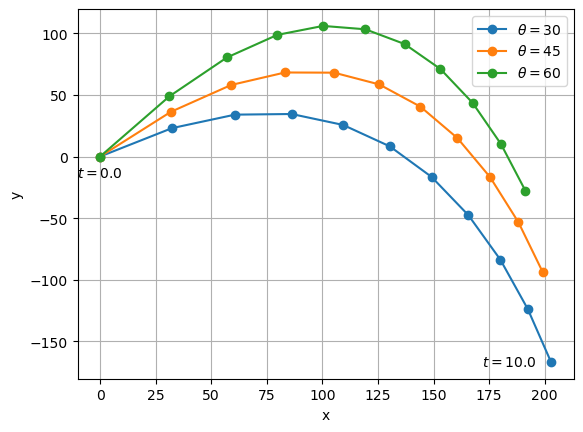

In [18]:
T_values = np.linspace(0, 10, 11)
theta_values = np.linspace(30, 60, 3)
for theta in theta_values:
    points = np.hstack([
        fly([0.0, 0.0, 35.0, theta], T)
        for T in T_values
    ])
    plt.plot(points[0], points[1], marker='o', label=f'$\\theta = {theta:.0f}$')
    if theta != theta_values[0]:
        continue
    plt.annotate(f'$t = {T_values[0]}$', xy=(points[0, 0], points[1, 0]), xytext=(0, -15),
                 textcoords='offset points', ha="center")
    plt.annotate(f'$t = {T_values[-1]}$', xy=(points[0, -1], points[1, -1]), xytext=(-50, 0),
                 textcoords='offset points', va="center")

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

### 2.3 Shoot function

In [19]:
v = MX.sym('v')
theta = MX.sym('theta')
theta_rad = theta * cas.pi / 180
shoot = Function(
    'shoot', 
    [v, theta, T], 
    [fly(cas.vertcat(0., 0., v * cas.cos(theta_rad), v * cas.sin(theta_rad)), T)]
)
xT = shoot(50, 30, 5)
xT

DM([155.243, -11.0833, 22.6012, -23.8282])

In [20]:
assert_array_almost_equal(xT, [[155.2433], [-11.0833], [22.6012], [-23.8282]], decimal=4)

### 2.4 Find time when ball hits the ground

In [21]:
v0 = DM(50)
theta0 = DM(30)
T = MX.sym('T')

xT = shoot(v0, theta0, T)
height = xT[1]

rf = cas.rootfinder('rf', 'newton', {'x': T, 'g': height})
rf

Function(rf:(x0,p[])->(x) Newton)

In [22]:
T0 = 5
res = rf(x0=T0)
res

{'x': DM(4.49773)}

In [23]:
assert np.isclose(res['x'], 4.49773)

### 2.5 Shot distance function

In [24]:
T = MX.sym('T')
xT = shoot(v, theta, T)
height = xT[1]

rf = cas.rootfinder('rf', 'newton', {'x': T, 'g': height, 'p': cas.vertcat(v, theta)})
rf

Function(rf:(x0,p[2])->(x) Newton)

In [25]:
T0 = DM(5)
res = rf(x0=T0, p=cas.vertcat(v, theta))
res

{'x': MX(rf(5, vertcat(v, theta)){0})}

In [26]:
xf = shoot(v, theta, res["x"])
shoot_distance = Function('shoot_distance', [v, theta], [xf[0]], ['v', 'theta'], ['xf'])
shoot_distance

Function(shoot_distance:(v,theta)->(xf) MXFunction)

In [27]:
distance = shoot_distance(50, 30)
distance

DM(143.533)

In [28]:
assert np.isclose(distance, 143.533)

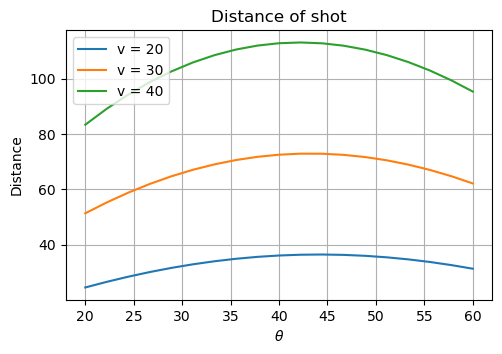

In [29]:
# Use a function so that workspace variables v, theta are not replaced

def make_distance_plot(shoot_distance, v_values, theta_values):
    fig, ax = plt.subplots(figsize=(5.5, 3.5))
    for v in v_values:
        distances = np.array([
            np.array(shoot_distance(v, theta)).item()
            for theta in theta_values
        ])
        ax.plot(theta_values, distances, label=f"v = {v:.0f}")
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('Distance')
    ax.set_title('Distance of shot')
    ax.legend()
    ax.grid()
    return ax

v_values = np.linspace(20, 40, 3)
theta_values = np.linspace(20, 60, 19)
make_distance_plot(shoot_distance, v_values, theta_values)
plt.show()

In [30]:
# Note: for some reason this fails:
# shoot_distance(40.0, 32.0)
# "cas.rootfinder process failed"

## 3. Optimizing for shooting angle

### 3.1 Find the launch angle that maximizes the distance covered

In [31]:
v0 = DM(30)
nlp = {
    'x': theta,
    'f': -shoot_distance(v0, theta)
}
solver = cas.nlpsol('solver', 'ipopt', nlp)
solver

Function(solver:(x0,p[],lbx,ubx,lbg[0],ubg[0],lam_x0,lam_g0[0])->(x,f,g[0],lam_x,lam_g[0],lam_p[]) IpoptInterface)

In [32]:
X0 = DM(30)
res = solver(x0=X0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        1

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [33]:
x_opt = res['x']
x_opt

DM(43.2223)

In [34]:
assert np.isclose(x_opt, 43.2223)

### 3.2 Maximize chance of a hole in one

In [35]:
cov_x = cas.diag([1, 1.2]) ** 2
cov_x

DM(
[[1, 00], 
 [00, 1.44]])

In [36]:
distance = shoot_distance(v, theta)
J = cas.jacobian(distance, cas.vertcat(v, theta))
J.shape

(1, 2)

In [37]:
# Approximation for covariance of distance
sigma_shoot_distance = J @ cov_x @ J.T

nlp = {
    'x': cas.vertcat(v, theta),
    'g': distance,
    'f': sigma_shoot_distance
}
solver = cas.nlpsol('solver', 'ipopt', nlp)
solver

Function(solver:(x0[2],p[],lbx[2],ubx[2],lbg,ubg,lam_x0[2],lam_g0)->(x[2],f,g,lam_x[2],lam_g,lam_p[]) IpoptInterface)

In [38]:
x0 = cas.vertcat(30, 45)
res = solver(x0=x0, lbg=80, ubg=80)
res["x"]

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5182999e+01 7.22e+00 7.26e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

DM([34.1584, 57.087])

In [39]:
assert_array_almost_equal(res["x"], [[34.1584], [57.0871]], decimal=4)